# Install packages and dependencies

In [1]:
!pip install datasets
!pip install evaluate
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/someonelearn/Local-Energy
%cd Local-Energy

Cloning into 'Local-Energy'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 92 (delta 20), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 36.36 KiB | 12.12 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/content/Local-Energy


In [3]:
import torch
from tqdm.auto import tqdm

# Load image processor

In [4]:
from transformers import ViTImageProcessor, ViTForImageClassification
device = "cuda"

In [5]:
model_name = "google/vit-base-patch16-224"
image_processor = ViTImageProcessor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

# Load and preprocess dataset

In [ ]:
img_col = "img"
lab_col = "fine_label"

In [6]:
mean = 0
std = 20
n_noised_img = 1

In [7]:
from utils.noise_addition import GaussianNoise
noise_helper = GaussianNoise(mean, std, n_noised_img)

In [8]:
from datasets import load_dataset

dataset = load_dataset("uoft-cs/cifar100")

training_ds = dataset["train"].shuffle().train_test_split(0.2)
val_ds = dataset["test"]

features = training_ds["train"].features
labels = features[lab_col].names
num_labels = len(labels)

print(num_labels)

README.md:   0%|          | 0.00/9.98k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

100


In [9]:
from datasets import Dataset
def add_noise_data(dataset):
  gaussian_ds = []
  for data in tqdm(dataset):
      img = data[img_col]
      label = data[lab_col]
      for c in range(n_noised_img):
          gaussian_ds.append({
              "image" : noise_helper.transform_type(noise_helper.add_noise(img)),
              "label" : label
          })
  return Dataset.from_list(gaussian_ds)

In [10]:
training_ds["train"] = add_noise_data(training_ds["train"])
training_ds["test"] = add_noise_data(training_ds["test"])

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
def transform(examples):
  # convert all images to RGB format, then preprocessing it using our image processor
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")

  # we also shouldn't forget about the labels
  inputs["labels"] = torch.tensor(examples["label"])

  return inputs

# use the with_transform() method to apply the transform to the dataset on the fly during training
training_ds = training_ds.with_transform(transform)

# Load and train classifier

In [12]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True,
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [14]:
from evaluate import load
import numpy as np

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [15]:
from transformers import Trainer, TrainingArguments

In [16]:
# defining the training arguments
training_args = TrainingArguments(
  output_dir=f"trained_classifier", # output directory
  per_device_train_batch_size=32, # batch size per device during training
  eval_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=5,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=200,                # number of update steps before saving checkpoint
  eval_steps=200,                # number of update steps before evaluating
  logging_steps=200,             # number of update steps before logging
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)

In [17]:
# Create Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=training_ds["train"], # the training dataset
    eval_dataset=training_ds["test"],  # the evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

<ipython-input-17-ce8c8f02bc23>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
200,3.661800,2.644655,0.425200,0.396279
400,2.152400,1.784245,0.577600,0.571345
600,1.584800,1.453296,0.644300,0.636937
800,1.301200,1.223780,0.691300,0.686997
1000,1.174300,1.135201,0.708900,0.704982
1200,1.064700,1.038361,0.726700,0.725827
1400,0.801400,1.018345,0.728900,0.725122
1600,0.666100,1.002259,0.730800,0.729389
1800,0.684400,0.983575,0.741300,0.738252
2000,0.630700,0.952012,0.743500,0.741897


KeyboardInterrupt: 

In [20]:
model = trainer.model

# LoEn Evaluation

In [21]:
from utils.cal_energy import cal_energy_score

In [22]:
n_sample = 64

In [35]:
#feed image to model to get the logits before softmax
def model_forward(x):
    x = x.to(device)
    with torch.no_grad():
        output = model(x, output_hidden_states=True)
    logits =  output.logits
    return logits

In [24]:
sampler = GaussianNoise(mean, std, n_sample)

In [36]:
def preprocess(image):
    noisy_images = []
    for i in range(n_sample):
      noisy_images.append(
        sampler.add_noise(image)
      )
    imgs = [image] + noisy_images
    pixel_values = image_processor([img.convert("RGB") for img in imgs], return_tensors="pt")
    return pixel_values

In [45]:
y_score = torch.tensor([])
y_true = torch.tensor([])

for data in tqdm(val_ds):
    pixel_values = preprocess(data[img_col])
    label = torch.tensor([data[lab_col]])

    logits = model_forward(pixel_values)
    pred = logits[0].argmax(dim=-1, keepdim=True)

    y_score = torch.concat([y_score, cal_energy_score(logits).cpu()])
    y_true = torch.concat([y_true, label != pred.cpu()])

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor([49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
        49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
        49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
        49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49])
tensor([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
tensor([72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72,
        72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72,
        72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72,
        72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72])
tensor([51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
        51, 51, 51, 51, 51, 51, 51, 51, 5

KeyboardInterrupt: 

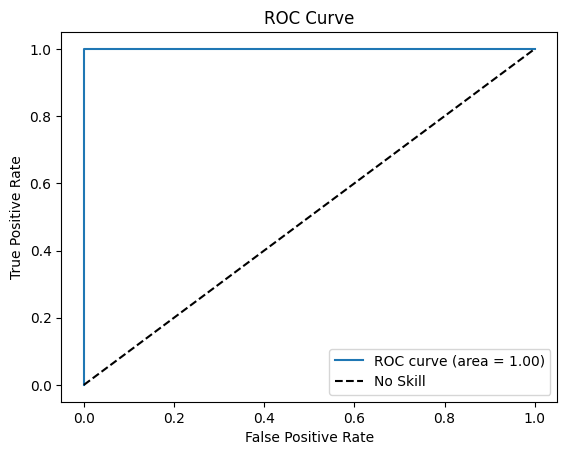

In [47]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()